In [1]:
%%capture
# Setup: Installing packages we will need in this notebook
%pip install pyfmreader
%pip install matplotlib

In [2]:
# 1. Import pyafmreader loadfile and matplotlib
from pyfmreader import loadfile
import matplotlib.pyplot as plt
import os

# Get documentation about loadfile function
help(loadfile)

Help on function loadfile in module pyfmreader.pyfmreader:

loadfile(filepath)
    Load AFM file. 
    
    Supported formats:
        - JPK --> .jpk-force, .jpk-force-map, .jpk-qi-data
        - JPK Thermal --> .tnd
        - NANOSCOPE --> .spm, .pfc, .00X
        - UFF --> .uff
    
            Parameters:
                    filepath (str): Path to the file.
            
            Returns:
                    If JPK, NANOSCOPE OR UFF:
                        UFF (uff.UFF): Universal File Format object containing loaded data.
                    If JPK Thermal:
                        Amplitude (m^2/V) (np.array),
                        Frequencies (Hz) (np.array),
                        Fit-Data (m^2/V) (np.array),
                        Parameters (dict)



In [3]:
# 2. Load one of the test files
NANOSC_PFC_PATH = '../tests/testfiles/08171528.0_00001.pfc'

NANOSC_PFC_FILE = loadfile(NANOSC_PFC_PATH)

type(NANOSC_PFC_FILE)

pyfmreader.uff.UFF

In [4]:
# 3. Get file metadata
metadata = NANOSC_PFC_FILE.filemetadata

for key, item in metadata.items():
    print(f"{key} : {item}\n") 

file_path : ../tests/testfiles/08171528.0_00001.pfc

Entry_filename : 08171528.0_00001.pfc

file_size_bytes : 67451968

file_type : pfc

UFF_code : _1_2_3_4_5

Entry_UFF_version : 0

version : 0x0940B020

instru : BioScope Resolve

scanner : beta1_beta1.scn

zscan_sens_nmbyV : 29.12

force_volume : 1

xoffset_nm : 203.125

yoffset_nm : -351.563

piezo_nb_sampsline : 256

xy_closed_loop : Off

z_closed_loop : On

PFC_nb_samppoints : 256

NEW_sync_dist : 88

QNM_sync_dist : 89

PFC_amp : 10.0

ramp_size_V : 20.0

PFC_freq : 2.0

peakforce : 1

defl_sens_nmbyV : 10.0

sens_z_sensor : 156.4861

scan_rate_Hz : 81.3802

speed_forward_Vbys : 242.165

speed_reverse_Vbys : 242.165

nb_point_approach : 128

nb_point_retract : 128

trigger_mode : Relative

FDC_nb_sampsline : 256

defl_sens_corr : 1.08

defl_sens_Vbybyte : 0.000375

FV_ima_offset : 80960

FV_data_length : 262144

bytes_per_pxl : 4

FV_nb_sampsline : 256

FV_nb_lines : 256

FV_ima_scanX : 2e-06

FV_ima_scanY : 2e-06

FV_Zsens : 5.7

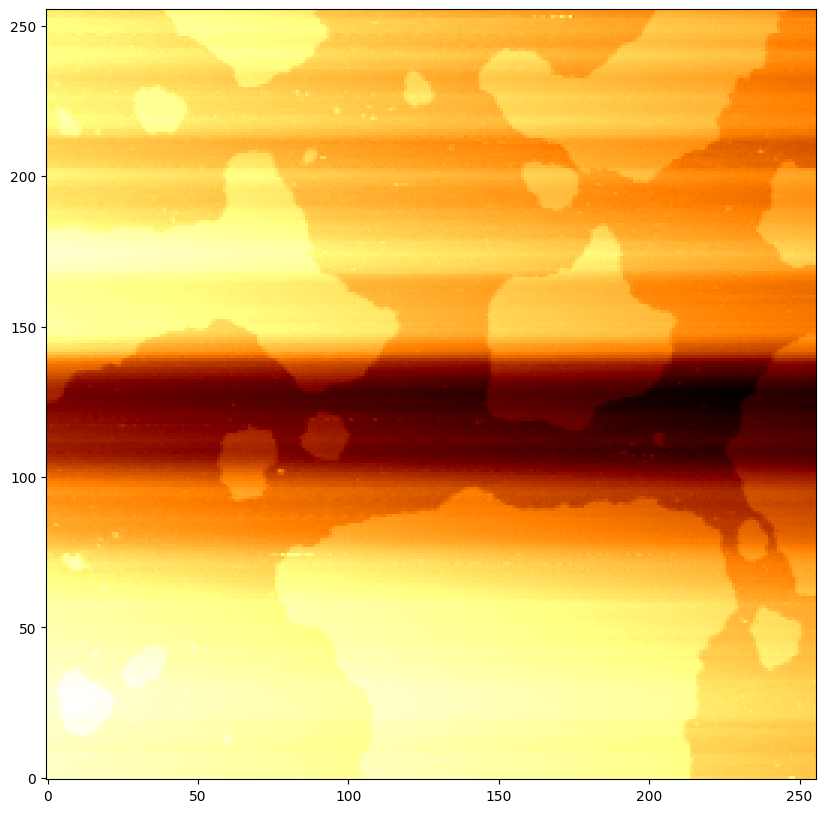

In [5]:
# 4. Get force volume piezo image and plot it
piezoimg = NANOSC_PFC_FILE.getpiezoimg()

plt.figure(figsize=(10,10))
plt.imshow(piezoimg[:, :, 0], cmap='afmhot', origin='lower')
plt.show()

In [6]:
# 5. Get force curve at index 0
FC = NANOSC_PFC_FILE.getcurve(0)

type(FC)

pyfmreader.utils.forcecurve.ForceCurve

In [7]:
help(FC.preprocess_force_curve)

Help on method preprocess_force_curve in module pyfmreader.utils.forcecurve:

preprocess_force_curve(deflection_sens, height_channel_key, y0=None) method of pyfmreader.utils.forcecurve.ForceCurve instance
    Computes Vertical Deflection in m and populates the vdeflection, zheight 
    and time properties for each segment in the force curve.
    
    vDeflection(m) = (vDeflection(V) - baseline(V)) * deflection_sens(m/V)
    
    if y0 is not None:
        vDeflection(m) = (vDeflection(V) - y0(V)) * deflection_sens(m/V)
    
            Parameters:
                    deflection_sens (float): In m/V
                    height_channel_key (str): Dictionary key to find height data in self.segment_formated_data.
                    y0 (float): Manual offset for the vertical deflection, in Volts.
            
            Returns: None



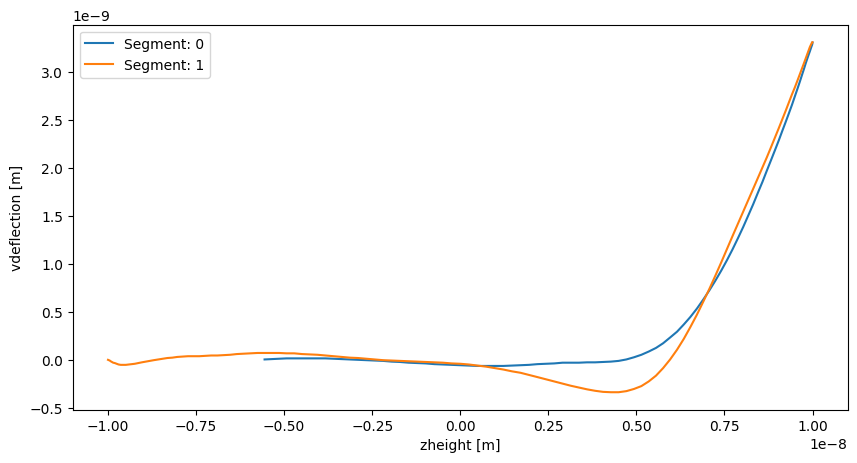

In [8]:
# 6. Preprocess curve with the deflection sens in the header
defl_sens = metadata['defl_sens_nmbyV'] / 1e09 # nm/V --> m/V
FC.preprocess_force_curve(defl_sens, metadata['height_channel_key'])
plt.figure(figsize=(10,5))
for segid, segment in FC.get_segments():
    plt.plot(segment.zheight, segment.vdeflection, label=f'Segment: {segid}')
plt.xlabel('zheight [m]')
plt.ylabel('vdeflection [m]')
plt.legend()
plt.show()

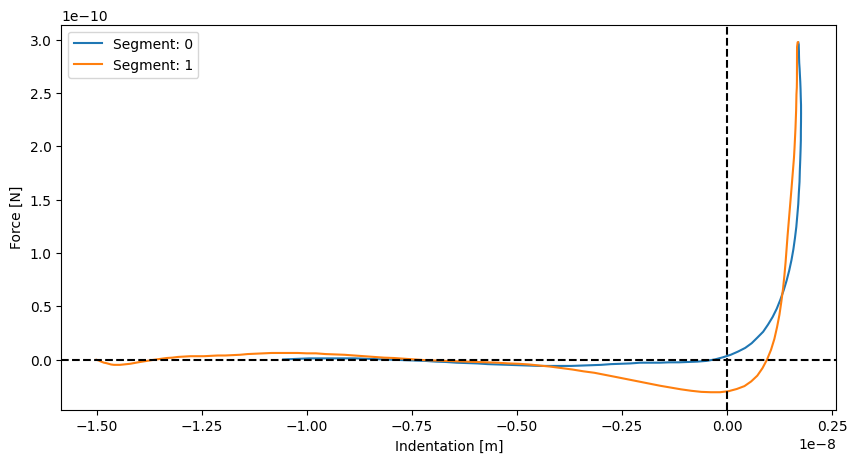

In [9]:
# 7. Get Force vs Indentation curve
poc = [0.5 * 1e-8, 0.0] # in nm
spring_k = metadata['spring_const_Nbym']
FC.get_force_vs_indentation(poc, spring_k)
plt.figure(figsize=(10,5))
for segid, segment in FC.get_segments():
    plt.plot(segment.indentation, segment.force, label=f'Segment: {segid}')
plt.axhline(y=0, color='k', linestyle='--')
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Indentation [m]')
plt.ylabel('Force [N]')
plt.legend()
plt.show()

In [10]:
# 8. Get segment 0
FC_segments = FC.get_segments()
_, segment_0 = FC_segments[0]
type(segment_0)

pyfmreader.utils.segment.Segment

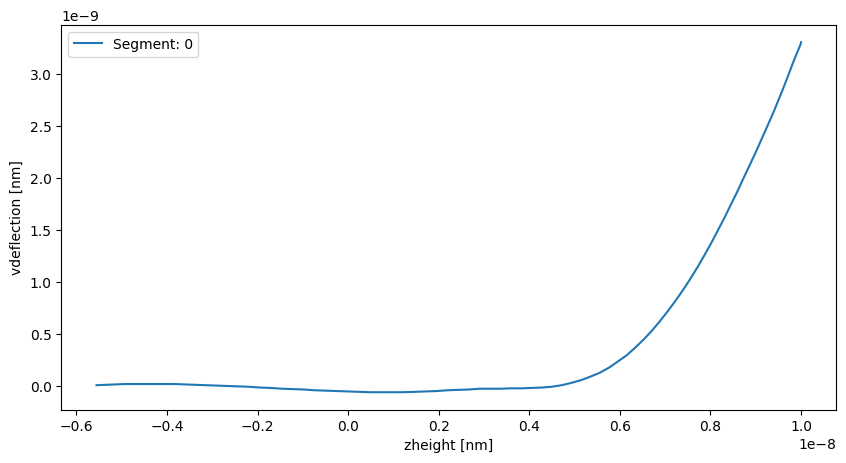

In [11]:
# 9. Plot only segment 0
plt.figure(figsize=(10,5))
plt.plot(segment_0.zheight, segment_0.vdeflection, label=f'Segment: 0')
plt.xlabel('zheight [nm]')
plt.ylabel('vdeflection [nm]')
plt.legend()
plt.show()

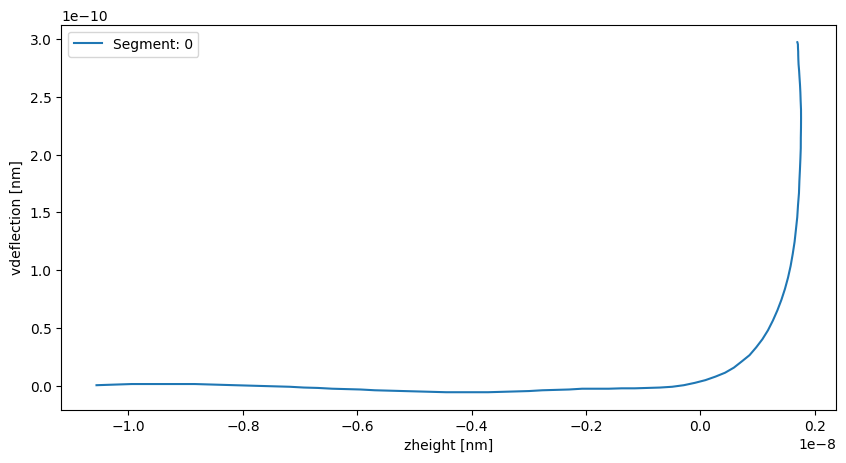

In [12]:
# 9. Get force vs indentation for segment 0
plt.figure(figsize=(10,5))
plt.plot(segment_0.indentation, segment_0.force, label=f'Segment: 0')
plt.xlabel('zheight [nm]')
plt.ylabel('vdeflection [nm]')
plt.legend()
plt.show()